## Working Directory Setup

It is suggested to use visual studio code as coding IDE.

Follow the instructions from https://spiral-agenda-bd3.notion.site/Spark-Cluster-Deployment-with-Docker-b1a04eec95624b298037537f1ef6f333?pvs=4 to build the hadoop and spark cluster with docker.

Your working directory should be the folder where you put docker-compose.yml.


## Data Preparation


1. Download the ml-25m(250MB) dataset from this link (https://grouplens.org/datasets/movielens/)
2. Unzip and move the dataset (6 csv files) to the folder input_files
3. Type the following command to upload the dataset to HDFS

In [ ]:
docker exec namenode hdfs dfs -mkdir /input_files
docker exec namenode hdfs dfs -put ./input_files/ /

We can only access the HDFS file system on the namenode, we need to put the files onto HDFS through the namenode.

For ease of use, we mount the folder "input_files" so that the namenode container share the folder "input_files" with the machine.

Check docker-compose.yml to learn how to mount a folder by setting volumes configs.


In [ ]:
  namenode:
    image: bde2020/hadoop-namenode:2.0.0-hadoop3.2.1-java8
    container_name: namenode
    hostname: namenode
    volumes:
      - ./hadoop/namenode:/hadoop/dfs/name
      - ./input_files:/input_files
    environment:
      - CLUSTER_NAME=test
    env_file:
      - ./hadoop.env
    ports:
      - "9870:9870" 
      - "9000:9000"
      - "8020:8020"

Once you put files into that folder, the namenode container can also access it.

If you are not familar with docker, here is the explanation to the above command.

The commoand can be separated into few parts.

1. docker -- we are running docker command
2. exec -- execute
3. namenode -- the command will run on the namenode container
4. hdfs dfs -put /input_files/ / -- This is the body of the command

The command is trying to upload all the files from "input_files" foler on namenode onto the "" folder on hdfs

You can check the hdfs file system on localhost:9870

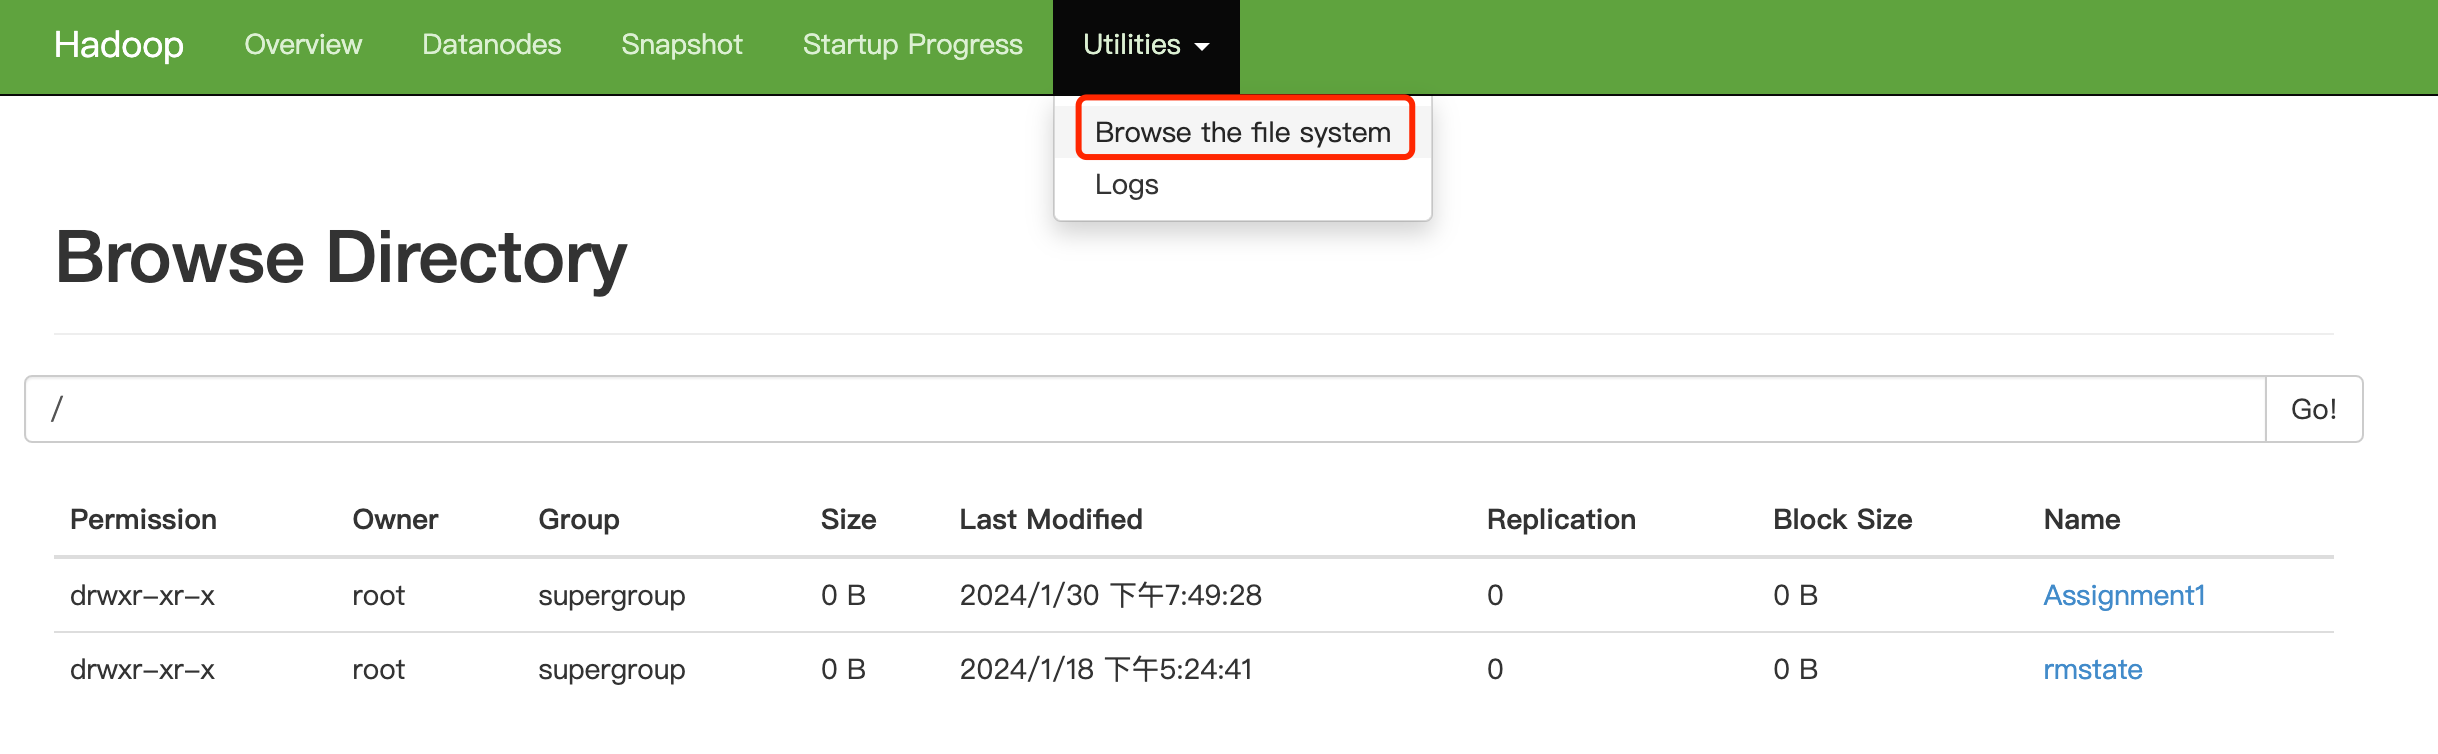

---

### Q0. Write the MapReduce code to find the movie with the longest title. (Demo)

To run the program, place this notebook file in the "code" folder and open it using Docker JupyterLab at localhost:9999.

In [ ]:
from pyspark.sql import SparkSession

# the following scripts is for starting a spark program
spark = SparkSession \
    .builder \
    .appName('Ass1_Q0') \
    .master('spark://spark-master:7077') \
    .getOrCreate()
# this line is to omit unnecessary info
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

# read the file in plain text to RDD
rdd = sc.textFile('hdfs://namenode:9000/input_files/movies.csv')

# print the first 5 lines of the RDD
for line in rdd.take(5):
    print(line)

# the first line of the file contains the header "movieId,title,genres", we should ignore this line in our code.
header = rdd.first()
rdd = rdd.filter(lambda x:x != header)

# each line of rdd contains 3 attributes separated by a comma
# the title would be the second object of split(',')
# we map the line to a tuple (title,len_of_title)
rdd = rdd.map(lambda x:(x.split(',')[1],len(x.split(',')[1])))

# after the mapping,each line of rdd would be converted to a tuple which contains movie title and its length
# a reduce with a simple comparison to get the movie with the longest title
result = rdd.reduce(lambda y,x:x if x[1]>y[1] else y)

print(result)

spark.stop()

### Q1. Write the MapReduce code to calculate the average rating in 2018 of each user. (25%) 


Tips:
1. You may need to do a type conversion in mapping
2. You should use reduceByKey but not reduce
3. You can have two reduce progress, one for calculating the amount of the rating, one for summing up the rating
4. The avergae rating would be the quotient of the summation and the amount

In [ ]:
from pyspark.sql import SparkSession

# the following scripts is for starting a spark program
spark = SparkSession \
    .builder \
    .appName('Ass1_Q1') \
    .master('spark://spark-master:7077') \
    .getOrCreate()
# this line is to omit unnecessary info
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

rdd = sc.textFile('hdfs://namenode:9000/input_files/ratings.csv')

# write your code here


spark.stop()

### Q2. Write MapReduce code to calculate the average rating for movies in the genres of 'Comedy' and 'Romance' respectively.(25%)


Tips: 
1. Get all the movies id which in genres "Comedy" and "Romance" by executing a MapReduce program on the movies.csv rdd
2. Run a filter on the rating.csv rdd to preserve only the movies whose id can be found in the previous result
3. The result of the mapping should contains only two types of key Comedy and Romance. The value would be the rating of that movie.
4. Movie may belongs to Comedy and Romance at the same time. In this case, you should map it to two tuples.
5. You should use reduceByKey but not reduce.6. The output should consist of two floating-point numbers indicating the average ratings of movies in the 'Romance' and 'Comedy' genres respectively. 

In [ ]:
from pyspark.sql import SparkSession

# the following scripts is for starting a spark program
spark = SparkSession \
    .builder \
    .appName('Ass1_Q2') \
    .master('spark://spark-master:7077') \
    .getOrCreate()
# this line is to omit unnecessary info
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

rdd_rating = sc.textFile('hdfs://namenode:9000/input_files/ratings.csv')
rdd_movies = sc.textFile('hdfs://namenode:9000/input_files/movies.csv')
# write your code here

spark.stop()


### Q3. Write the MapReduce code to calculate the similarity between user pair. (30%)

Given two users id (A: 20,B: 30), your task is to compute the similarity score by the given formula.
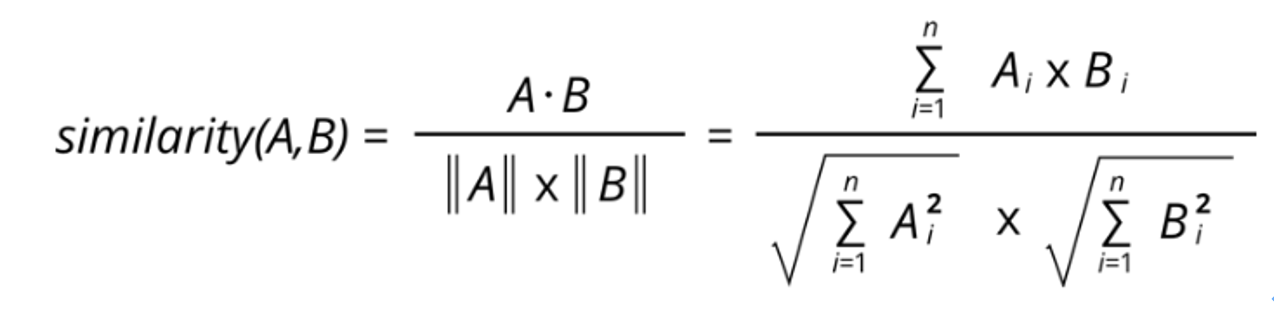


The following steps serve as a reference for completing the task. You are welcome to follow these steps or create your own. Please ensure to include explanations in your submission.


- Part 1: Employ the "filter" and "countByKey" functions to retain the rdd records that correspond to the specified users 
- Part 2: Compute the denominator of the formula

- Part 3: Compute the Euclidean norm for each user

- Part 4: Compute the rooted Euclidean norm rating for each user pair

- Part 5: Compute the numerator of the formula 

- Part 6: Compute the similarity score



Tips:
1. Use filter to preserve only those records rated by user 1 and user 2 
2. Only a movie that receives ratings from both user 1 and user 2 will be considered for similarity computation
3. The reduce in pyspark does not have a initial value, it would start by merging the first two elements of the rdd. You may face a case that the rdd element is a tuple, but you are trying to reduce it to a scalar. A simple solution is to add a type checking in the lambda function

    An example is shown as below:

    `rdd.reduce(lambda y,x:y* sqrt(x[1]) if type(y) is float else sqrt(y[1])*sqrt(x[1]))`



In [ ]:
from pyspark.sql import SparkSession
from math import sqrt 

# the following scripts is for starting a spark program
spark = SparkSession \
    .builder \
    .appName('Ass1_Q3') \
    .master('spark://spark-master:7077') \
    .getOrCreate()
# this line is to omit unnecessary info
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

rdd = sc.textFile('hdfs://namenode:9000/input_files/ratings.csv')
# header = "userId,movieId,rating,timestamp"
user_A = "20"
user_B = "30"

# write your code here

spark.stop()

### Q4. Devise a solution for effectively calculating the similarity score matrix, which encompasses all similarity scores for every pair of users. (20%)
